In [104]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

from pytz import timezone
from geopy.distance import geodesic

import matplotlib
import matplotlib.dates as mdates

In [105]:
matplotlib.rcParams['timezone'] = 'Asia/Singapore'

In [106]:
output_dir = '../metadata/07-06-2024'
filename = 'location-error.png'

In [107]:
start_location = (1.2907799798995256, 103.77331998199224)
stop_location = (1.3093499187380075, 103.89385996386409)

In [108]:
conn = psycopg2.connect(
    host="localhost",
    database="gpx",
    user="root",
    password="root"
)

In [109]:
def query_postgis(device_table_name):
    query = f"""
WITH ordered_route_points AS (
    SELECT location
    FROM gpx_route
    ORDER BY id
),
route_linestring AS (
    SELECT ST_MakeLine(ST_Transform(location, 3857)) AS route
    FROM ordered_route_points
)

SELECT
    time,
    ST_Y(location) AS latitude,
    ST_X(location) AS longitude,
    ST_Distance(ST_Transform(location, 3857), (SELECT route FROM route_linestring)) AS distance_to_route
FROM
    {device_table_name};
"""
    
    with conn.cursor() as cur:
        cur.execute(query)
        rows = cur.fetchall()

    df = pd.DataFrame(rows, columns=["time", "latitude", "longitude", "distance_to_route"])
    df['time'] = df['time'].apply(lambda x: x.astimezone(timezone('Asia/Singapore')))
    
    return df

In [110]:
garmin_df = query_postgis('garmin_route')
garmin_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-07 22:53:05+08:00,1.283562,103.781514,494.764376
1,2024-06-07 22:53:14+08:00,1.283654,103.781455,491.109697
2,2024-06-07 22:53:16+08:00,1.283691,103.781420,490.597321


In [111]:
polar_df = query_postgis('polar_route')
polar_df.head(3)

,time,latitude,longitude,distance_to_route
0,2024-06-07 22:53:00.834000+08:00,1.283608,103.781545,488.603794
1,2024-06-07 22:53:01.835000+08:00,1.283610,103.781528,489.639968
2,2024-06-07 22:53:02.834000+08:00,1.283607,103.781507,491.464282


In [112]:
def crop_route(df, start_point_count):
    df['start_distance'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), start_location).meters, axis=1)
    df['stop_distance'] = df.apply(lambda row: geodesic((row['latitude'], row['longitude']), stop_location).meters, axis=1)
    
    start_point_idx = df.iloc[:start_point_count]['start_distance'].idxmin()
    end_point_idx = df.iloc[-200:]['stop_distance'].idxmin()
    
    df = df.iloc[start_point_idx:end_point_idx]
    
    return df

In [113]:
garmin_df = crop_route(garmin_df, 200)
garmin_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
124,2024-06-07 23:03:07+08:00,1.290838,103.773510,100.721742,22.090479,13549.387973
125,2024-06-07 23:03:11+08:00,1.290956,103.773532,87.334900,30.575429,13545.018879
126,2024-06-07 23:03:17+08:00,1.291113,103.773580,69.143515,46.820253,13537.097956


In [114]:
polar_df = crop_route(polar_df, 600)
polar_df.head(3)

,time,latitude,longitude,distance_to_route,start_distance,stop_distance
579,2024-06-07 23:03:08.834000+08:00,1.290753,103.773303,116.761223,3.481109,13573.535839
580,2024-06-07 23:03:09.834000+08:00,1.290780,103.773287,114.778557,3.707340,13574.922092
581,2024-06-07 23:03:10.835000+08:00,1.290808,103.773270,112.703678,6.385075,13576.282473


In [115]:
desc_polar_df = polar_df['distance_to_route'].describe().to_frame()
desc_polar_df.columns = ['Polar']

desc_garmin_df = garmin_df['distance_to_route'].describe().to_frame()
desc_garmin_df.columns = ['Garmin']

merged_desc = pd.concat([desc_polar_df, desc_garmin_df], axis=1)
merged_desc.to_csv('/tmp/merged_desc.csv')

print(merged_desc)

              Polar        Garmin
count  22923.000000  4.788000e+03
mean      11.014874  7.330054e+00
std       12.081661  1.003351e+01
min        0.000279  8.480975e-08
25%        3.408405  1.771783e+00
50%        7.527448  4.233043e+00
75%       14.147500  9.332433e+00
max      116.761223  1.007217e+02


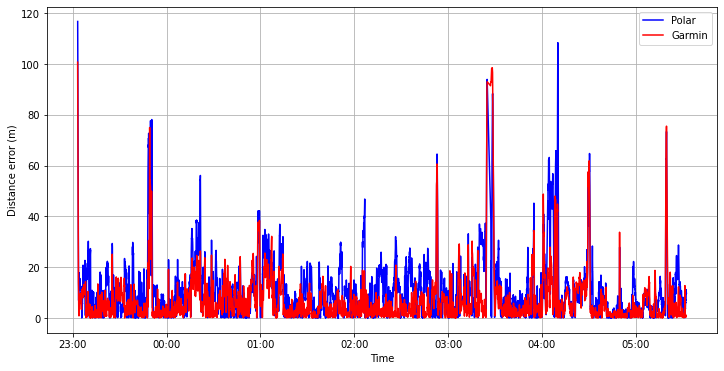

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(polar_df['time'], polar_df['distance_to_route'], color='blue', label='Polar')
plt.plot(garmin_df['time'], garmin_df['distance_to_route'], color='red', label='Garmin')
plt.xlabel('Time')
plt.ylabel('Distance error (m)')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.savefig(output_dir + '/' + filename)

In [117]:
def get_total_distance(df):
    df['prev_latitude'] = df['latitude'].shift(1)
    df['prev_longitude'] = df['longitude'].shift(1)

    df = df.dropna().reset_index(drop=True)

    df['distance'] = df.apply(lambda x: geodesic((x['prev_latitude'], x['prev_longitude']), (x['latitude'], x['longitude'])).meters, axis=1)
    df['accumulated_distance'] = df['distance'].cumsum()
    
    return df

In [118]:
polar_df = get_total_distance(polar_df)
polar_df.iloc[-1]['accumulated_distance']

50497.246318562145

In [119]:
garmin_df = get_total_distance(garmin_df)
garmin_df.iloc[-1]['accumulated_distance']

48070.81283248653

In [120]:
polar_df.iloc[-1]['accumulated_distance'] - garmin_df.iloc[-1]['accumulated_distance']

2426.4334860756135